In [1]:
# code still needs do be organized

In [2]:
# %% [1] Imports & Matplotlib
import math
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import patheffects as pe

# Colossus
from colossus.cosmology import cosmology
from colossus.halo import profile_composite, profile_nfw, profile_einasto, profile_hernquist, mass_so, profile_dk14
from colossus.utils import constants as col_consts
from colossus.halo import profile_outer  # only for constructing composite refs

# NumCosmo
from numcosmo_py import Nc, Ncm

# Notebook style
%matplotlib inline
mpl.rcParams.update({
    "axes.xmargin": 0,
    "figure.dpi": 110,
    "text.usetex": True,              # use LaTeX for all text
    "font.serif": ["Computer Modern"]
})
np.set_printoptions(suppress=True)


In [3]:
# %% [2] Cosmology (Colossus → NumCosmo mirror) & Shared Params
# Colossus cosmology
cosmo_col = cosmology.setCosmology("planck18")
Omega_c_col = cosmo_col.Om0 - cosmo_col.Ob0
Omega_b_col = cosmo_col.Ob0
h_col       = cosmo_col.H0 / 100.0

# NumCosmo cosmology with parameters matched from Colossus
Ncm.cfg_init()
cosmo = Nc.HICosmoDEXcdm()
cosmo.omega_x2omega_k()
cosmo.param_set_by_name("H0",      cosmo_col.H0)
cosmo.param_set_by_name("Omegak",  cosmo_col.Ok(0.0))
cosmo.param_set_by_name("w",       cosmo_col.w0)
cosmo.param_set_by_name("Omegab",  Omega_b_col)
cosmo.param_set_by_name("Omegac",  Omega_c_col)
cosmo.param_set_by_name("ENnu",    cosmo_col.Neff)
cosmo.param_set_by_name("Tgamma0", cosmo_col.Tcmb0)

# Shared parameters
#z      = 0.2
Delta  = 200.0
#Mvir   = 1.0e15       # Msun
cvir   = 5.0
#a      = 1.0 / (1.0 + z)
r      = 10.0 ** np.arange(-1, +5.31, 0.02) * 1.0e-3  # Mpc (physical)
alpha_ein = 0.18
#log10Mvir = math.log10(Mvir)


In [4]:
import math
import numpy as np
from itertools import product

def _pivot_radius_mpc(cosmo_nc, pivot, pivot_factor, R200m_mpc=None):
    h = cosmo_nc.h()
    p = str(pivot).lower()
    if p == 'fixed':  # pivot_factor in kpc/h
        return (float(pivot_factor) / h) * 1.0e-3
    elif p in ('r200m', '200m'):
        if R200m_mpc is None:
            raise ValueError("R200m_mpc must be provided when pivot='R200m'.")
        return float(pivot_factor) * float(R200m_mpc)
    else:
        raise ValueError(f"Unsupported pivot='{pivot}'.")

def inner_scale_mass_preserving_numeric(Mvir_Msun, Rvir_mpc, rho_outer_fn,
                                        n_rad=4000, r_min_factor=1e-6):
    r_min = max(Rvir_mpc * r_min_factor, 1e-12)
    rr    = np.logspace(np.log10(r_min), np.log10(Rvir_mpc), n_rad)
    rho_o = rho_outer_fn(rr)
    M_out = 4.0 * math.pi * np.trapz(rho_o * rr**2, rr)
    scale = 1.0 - (M_out / float(Mvir_Msun))
    return float(scale), float(M_out)

def make_xi_provider_colossus(cosmo_col, z):
    Rmin, Rmax = 1.0e-3, 1.0e4
    try:
        Rgrid = np.asarray(cosmo_col.R_xi, dtype=float)
        if Rgrid.size >= 2:
            Rmin, Rmax = float(Rgrid[0]), float(Rgrid[-1])
    except Exception:
        pass

    def xi_of_RcMpcH(R):
        R = np.asarray(R, dtype=float)
        R_clip = np.clip(R, Rmin, Rmax)
        return cosmo_col.correlationFunction(R_clip, z=z)  # linear xi by default

    xi_of_RcMpcH.Rmin, xi_of_RcMpcH.Rmax = Rmin, Rmax
    return xi_of_RcMpcH


def run_case(
    *,
    z,
    Mvir,
    Delta=200.0,
    cvir=5.0,
    alpha_ein=0.18,
    r=None,
    cosmo_col=None,
    cosmo_nc=None,
    h_col=None,
    dens_factor=None,
):
    """
    Run one (z, Mvir) case.
    Returns a dict with the arrays you currently compute (inner + outer comparisons).
    """

    if r is None:
        r = 10.0 ** np.arange(-1, +5.31, 0.02) * 1.0e-3  # Mpc (physical)

    # ---------- densities that depend on z ----------
    mean_density = Nc.HaloCMParam.new(Nc.HaloMassSummaryMassDef.MEAN, Delta)
    rho_m_nc = mean_density.rho_bg(cosmo_nc, z)  # Msun/Mpc^3

    # ---------- radii/conversions that depend on z and M ----------
    log10Mvir = math.log10(Mvir)
    
    r200m_kpch = mass_so.M_to_R(Mvir * h_col, z, mdef='200m')  # kpc/h
    r200m      = (r200m_kpch / h_col) * 1e-3                   # Mpc (physical)

    r_kpch    = r * h_col * 1.0e3                      # Mpc -> kpc/h
    rvir_kpch = mass_so.M_to_R(Mvir * h_col, z, mdef='vir')   # kpc/h
    rvir      = (rvir_kpch / h_col) * 1e-3             # Mpc (physical)

    # ============================================================
    # INNER PROFILES: NFW / Einasto / Hernquist
    # ============================================================

    # Colossus
    col_nfw  = profile_nfw.NFWProfile(M=(Mvir * h_col), c=cvir, z=z, mdef="vir")
    col_ein  = profile_einasto.EinastoProfile(M=(Mvir * h_col), c=cvir, z=z, mdef="vir", alpha=alpha_ein)
    col_hern = profile_hernquist.HernquistProfile(M=(Mvir * h_col), c=cvir, z=z, mdef="vir")

    col_rho_nfw  = col_nfw.density(r_kpch)  * dens_factor
    col_rho_ein  = col_ein.density(r_kpch)  * dens_factor
    col_rho_hern = col_hern.density(r_kpch) * dens_factor

    # NumCosmo
    ms_n = Nc.HaloCMParam.new(Nc.HaloMassSummaryMassDef.VIRIAL, Delta)
    dp_nfw = Nc.HaloDensityProfileNFW.new(ms_n)
    ms_n["cDelta"]      = cvir
    ms_n["log10MDelta"] = log10Mvir
    rho_nfw = np.array(dp_nfw.eval_density_array(cosmo_nc, r, 1.0, 1.0, z))

    ms_e = Nc.HaloCMParam.new(Nc.HaloMassSummaryMassDef.VIRIAL, Delta)
    dp_e = Nc.HaloDensityProfileEinasto.new(ms_e)
    ms_e["cDelta"]      = cvir
    ms_e["log10MDelta"] = log10Mvir
    dp_e["alpha"]       = alpha_ein
    rho_ein = np.array(dp_e.eval_density_array(cosmo_nc, r, 1.0, 1.0, z))

    ms_h = Nc.HaloCMParam.new(Nc.HaloMassSummaryMassDef.VIRIAL, Delta)
    dp_h = Nc.HaloDensityProfileHernquist.new(ms_h)
    ms_h["cDelta"]      = cvir
    ms_h["log10MDelta"] = log10Mvir
    rho_hern = np.array(dp_h.eval_density_array(cosmo_nc, r, 1.0, 1.0, z))

    abs_rel_nfw  = np.abs((rho_nfw  / col_rho_nfw)  - 1.0)
    abs_rel_ein  = np.abs((rho_ein  / col_rho_ein)  - 1.0)
    abs_rel_hern = np.abs((rho_hern / col_rho_hern) - 1.0)

    # =========================================
    # OUTER TERMS
    # =========================================

    # --- Outer mean ---
    ein_mean = profile_composite.compositeProfile(
        'einasto', outer_names=['mean'],
        M=(Mvir * h_col), c=cvir, z=z, mdef='vir', alpha=alpha_ein
    )
    rho_tot_co_mean = ein_mean.density(r_kpch) * dens_factor

    Vvir    = (4.0/3.0) * math.pi * (rvir**3)
    M_outer = rho_m_nc * Vvir
    scale_m = 1.0 - (M_outer / Mvir)
    rho_tot_nc_mean = (scale_m * rho_ein) + np.full_like(rho_ein, rho_m_nc)
    abs_rel_mean = np.abs((rho_tot_nc_mean / rho_tot_co_mean) - 1.0)

        # --- Outer power-law (safe norm per z,M) ---
    def rho_outer_powerlaw_nc(rr_mpc, norm=1.0, slope=2.0, pivot='fixed', pivot_factor=10_000.0, max_rho=1000.0, R200m_mpc=None):
        rr = np.asarray(rr_mpc, dtype=float)
        rp = _pivot_radius_mpc(cosmo_nc, pivot, pivot_factor, R200m_mpc=R200m_mpc)
        denom = (1.0 / float(max_rho)) + (rr / rp)**float(slope)
        return float(norm) * rho_m_nc / denom

    pivot_factor_kpch = 10_000.0
    slope_pl = 2.0
    max_rho_pl = 1000.0

    # 1) compute outer mass for norm=1 inside Rvir
    def M_outer_from_rho(rho_fn, Rvir_mpc, n_rad=4000):
        r_min = max(Rvir_mpc * 1e-6, 1e-12)
        rr = np.logspace(np.log10(r_min), np.log10(Rvir_mpc), n_rad)
        rho = rho_fn(rr)
        return 4.0 * math.pi * np.trapz(rho * rr**2, rr)

    Mout_pl_norm1 = M_outer_from_rho(
        lambda rr: rho_outer_powerlaw_nc(
            rr, norm=1.0, slope=slope_pl, pivot='fixed',
            pivot_factor=pivot_factor_kpch, max_rho=max_rho_pl
        ),
        rvir
    )

    # 2) choose a safe norm (cap outer mass to, say, 80% of Mvir)
    frac_cap = 0.80
    if Mout_pl_norm1 <= 0.0:
        norm_pl = 1.0
    else:
        norm_pl = min(1.0, frac_cap * (Mvir / Mout_pl_norm1))

    # 3) Colossus composite (reference) using safe norm
    ein_pl = profile_composite.compositeProfile(
        'einasto', outer_names=['pl'],
        M=(Mvir * h_col), c=cvir, z=z, mdef='vir',
        alpha=alpha_ein,
        norm=norm_pl, slope=slope_pl, pivot='fixed', pivot_factor=pivot_factor_kpch
    )
    rho_tot_co_pl = ein_pl.density(r_kpch) * dens_factor

    # 4) NumCosmo side: same safe norm + mass-preserving scale
    rho_pl_nc = rho_outer_powerlaw_nc(
        r, norm=norm_pl, slope=slope_pl, pivot='fixed',
        pivot_factor=pivot_factor_kpch, max_rho=max_rho_pl
    )

    scale_pl_nc, _ = inner_scale_mass_preserving_numeric(
        Mvir_Msun=Mvir, Rvir_mpc=rvir,
        rho_outer_fn=lambda rr: rho_outer_powerlaw_nc(
            rr, norm=norm_pl, slope=slope_pl, pivot='fixed',
            pivot_factor=pivot_factor_kpch, max_rho=max_rho_pl
        )
    )
    rho_tot_nc_pl = (scale_pl_nc * rho_ein) + rho_pl_nc
    abs_rel_pl = np.abs((rho_tot_nc_pl / rho_tot_co_pl) - 1.0)


    # --- Outer cf (2-halo) ---
    def rho_outer_cf_nc(rr_mpc, bias, xi_of_RcMpcH):
        rr = np.asarray(rr_mpc, dtype=float)
        R_cMpc_h = rr * (1.0 + z) * cosmo_nc.h()
        xi = np.asarray(xi_of_RcMpcH(R_cMpc_h), dtype=float)
        return rho_m_nc * float(bias) * xi

    ein_cf = profile_composite.compositeProfile(
        'einasto', outer_names=['cf'],
        M=(Mvir * h_col), c=cvir, z=z, mdef='vir',
        alpha=alpha_ein, bias=5.0
    )
    rho_tot_co_cf = ein_cf.density(r_kpch) * dens_factor

    xi_provider = make_xi_provider_colossus(cosmo_col, z)
    bias_fixed = 5.0
    rho_cf_nc = rho_outer_cf_nc(r, bias=bias_fixed, xi_of_RcMpcH=xi_provider)
    scale_cf_nc, _ = inner_scale_mass_preserving_numeric(
        Mvir_Msun=Mvir, Rvir_mpc=rvir,
        rho_outer_fn=lambda rr: rho_outer_cf_nc(rr, bias=bias_fixed, xi_of_RcMpcH=xi_provider)
    )
    rho_tot_nc_cf = (scale_cf_nc * rho_ein) + rho_cf_nc
    abs_rel_cf = np.abs((rho_tot_nc_cf / rho_tot_co_cf) - 1.0)

    # ============================================================
    # DK14: Colossus reference vs NC DK14 (NC Einasto + custom ftrans)
    # ============================================================

    # Colossus DK14 reference density
    dk14_co = profile_dk14.DK14Profile(M=(Mvir * h_col), c=cvir, z=z, mdef='vir')
    rho_dk14_col = dk14_co.density(r_kpch) * dens_factor  # Msun/Mpc^3

    # Extract DK14 transition parameters from Colossus
    alpha_dk = dk14_co.par['alpha']
    beta_dk  = dk14_co.par['beta']
    gamma_dk = dk14_co.par['gamma']
    rt_kpch  = dk14_co.par['rt']  # kpc/h
    rt_mpc = (rt_kpch / h_col) * 1e-3  # Mpc (physical)


    # Build NumCosmo Einasto with DK14 alpha
    ms_dk = Nc.HaloCMParam.new(Nc.HaloMassSummaryMassDef.VIRIAL, Delta)
    dp_e_dk = Nc.HaloDensityProfileEinasto.new(ms_dk)
    ms_dk["cDelta"]      = cvir
    ms_dk["log10MDelta"] = log10Mvir
    dp_e_dk["alpha"]     = alpha_dk

    rho_ein_dk_nc = np.array(dp_e_dk.eval_density_array(cosmo_nc, r, 1.0, 1.0, z))  # Msun/Mpc^3

    # Transition function fT in physical r but using kpc/h internally
    fT = (1.0 + (r_kpch / rt_kpch)**beta_dk)**(-gamma_dk / beta_dk)

    # Unnormalized DK14 profile
    rho_dk14_unc_nc = rho_ein_dk_nc * fT

    # Normalize to enforce M(<Rvir)=Mvir
    r_min = max(rvir * 1e-6, 1e-12)
    rr_int = np.logspace(np.log10(r_min), np.log10(rvir), 4000)
    rr_kpch_int = rr_int * h_col * 1e3
    fT_int = (1.0 + (rr_kpch_int / rt_kpch)**beta_dk)**(-gamma_dk / beta_dk)
    rho_int = np.array(dp_e_dk.eval_density_array(cosmo_nc, rr_int, 1.0, 1.0, z)) * fT_int

    M_inner = 4.0 * math.pi * np.trapz(rho_int * rr_int**2, rr_int)  # Msun
    scale_dk14 = Mvir / M_inner

    rho_dk14_nc = scale_dk14 * rho_dk14_unc_nc

    abs_rel_dk14 = np.abs((rho_dk14_nc / rho_dk14_col) - 1.0)


    return {
        "z": z,
        "Mvir": Mvir,
        "r": r,
        "r_kpch": r_kpch,
        "rvir": rvir,
        "r200m": r200m,
        "rho_m_nc": rho_m_nc,
        "abs_rel_inner": {
            "nfw": abs_rel_nfw,
            "ein": abs_rel_ein,
            "hern": abs_rel_hern,
        },
        "abs_rel_outer": {
            "mean": abs_rel_mean,
            "pl": abs_rel_pl,
            "cf": abs_rel_cf,
        },
                "dk14": {
            "rho_nc": rho_dk14_nc,
            "rho_col": rho_dk14_col,
            "abs_rel": abs_rel_dk14,
            "alpha": alpha_dk,
            "beta": beta_dk,
            "gamma": gamma_dk,
            "rt_kpch": rt_kpch,
            "scale": scale_dk14,
            "rt_mpc": rt_mpc
        }
    }


In [5]:
dens_factor = (h_col**2) * 1.0e9   

In [6]:
z_list = [0.6, 0.9, 1.2]
M_list = [5e13, 1e14, 5e14, 1e15]

from itertools import product

results = []
for z_i, M_i in product(z_list, M_list):
    out = run_case(
        z=z_i, Mvir=M_i,
        Delta=Delta, cvir=cvir, alpha_ein=alpha_ein,
        r=r,
        cosmo_col=cosmo_col, cosmo_nc=cosmo,
        h_col=h_col, dens_factor=dens_factor,
    )
    results.append(out)



/tmp/ipykernel_2504/1181116769.py:149: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return 4.0 * math.pi * np.trapz(rho * rr**2, rr)
/tmp/ipykernel_2504/1181116769.py:22: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  M_out = 4.0 * math.pi * np.trapz(rho_o * rr**2, rr)
/tmp/ipykernel_2504/1181116769.py:254: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  M_inner = 4.0 * math.pi * np.trapz(rho_int * rr_int**2, rr_int)  # Msun


In [7]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import numpy as np

def latex_sci(x, sig=2):
    """Return x as LaTeX scientific notation, e.g. 5.0e13 -> '5.0\\times 10^{13}'."""
    if x == 0:
        return "0"
    exp = int(np.floor(np.log10(abs(x))))
    mant = x / (10**exp)
    mant_str = f"{mant:.{sig-1}f}".rstrip("0").rstrip(".")
    return rf"{mant_str}\times 10^{{{exp}}}"


def plot_facets_by_z(
    results,
    zs,
    Ms,
    *,
    y_getter,
    ylabel,
    title_fmt=r"$z={z}$",
    line_label_fmt=r"$M={M:.1e}$",
    figsize=(10, 3.5),
    lw=1.6,
    legend_loc="lower left",
    xlim=None,
    ylim=None,
    cmap="magma",
    mark_radii=None,          # e.g. ["rvir", "r200m"] or ["rvir","r200m","rt"]
    mark_mass="median",       # "median" | "min" | "max" | float (exact M)
    mark_style=None,
):
    """
    Generic faceted plot:
      - one panel per z
      - one line per M in each panel
      - color = mass (consistent across panels)
      - optional radius markers per panel (using a representative mass)
    """

    # --- color mapping (mass → color) ---
    Ms_sorted = sorted(Ms)
    colors = plt.get_cmap(cmap)(np.linspace(0.15, 0.85, len(Ms_sorted)))
    mass_color = dict(zip(Ms_sorted, colors))

    # --- representative mass for markers ---
    if mark_mass == "median":
        M_ref = Ms_sorted[len(Ms_sorted)//2]
    elif mark_mass == "min":
        M_ref = Ms_sorted[0]
    elif mark_mass == "max":
        M_ref = Ms_sorted[-1]
    else:
        M_ref = float(mark_mass)

    # --- marker styling defaults ---
    if mark_style is None:
        mark_style = {}
    marker_defaults = dict(color="k", lw=0.9, alpha=0.35, ls=":")
    marker_defaults.update(mark_style)

    # labels for radii
    radius_label = {
        "rvir": r"$R_{\rm vir}$",
        "r200m": r"$R_{200m}$",
        "rt": r"$r_t$",
    }

    fig, axs = plt.subplots(1, len(zs), figsize=figsize, sharex=True, sharey=True)
    if len(zs) == 1:
        axs = [axs]

    for ax, z in zip(axs, zs):
        # --- plot curves ---
        for M in Ms_sorted:
            o = next(x for x in results if x["z"] == z and x["Mvir"] == M)
            y = y_getter(o)
            ax.loglog(o["r"], y, lw=lw, color=mass_color[M], label=rf"$M={latex_sci(M, sig=2)}$")

        # --- radius markers (once per panel) ---
        if mark_radii:
            o_ref = next(x for x in results if x["z"] == z and x["Mvir"] == M_ref)

            for key in mark_radii:
                if key == "rvir":
                    x = o_ref["rvir"]
                elif key == "r200m":
                    x = o_ref["r200m"]
                elif key == "rt":
                    # only meaningful for DK14 plots; safe-guard
                    x = o_ref.get("dk14", {}).get("rt_mpc", None)
                else:
                    raise ValueError(f"Unknown radius key: {key}")

                if x is not None and np.isfinite(x) and x > 0:
                    ax.axvline(x, **marker_defaults)
                    # small label near top (log coords)
                    ax.text(
                        x, 0.97, radius_label.get(key, key),
                        transform=ax.get_xaxis_transform(),
                        ha="center", va="top",
                        fontsize=8, color=marker_defaults["color"],
                        alpha=min(0.85, marker_defaults.get("alpha", 0.35) + 0.25),
                    )

        ax.set_title(title_fmt.format(z=z))

        # --- simplified log grid ---
        ax.grid(True, which="major", linestyle="-", linewidth=0.6, alpha=0.25)
        ax.xaxis.set_minor_locator(mticker.NullLocator())
        ax.yaxis.set_minor_locator(mticker.NullLocator())

        if xlim is not None:
            ax.set_xlim(*xlim)
        if ylim is not None:
            ax.set_ylim(*ylim)

    axs[0].set_ylabel(ylabel)
    for ax in axs:
        ax.set_xlabel(r"$r\;\mathrm{Mpc}$")

    axs[-1].legend(frameon=False, fontsize=8, loc=legend_loc, title="Mass", title_fontsize=9)

    plt.tight_layout()
    return fig, axs


In [8]:
zs = z_list
Ms = M_list

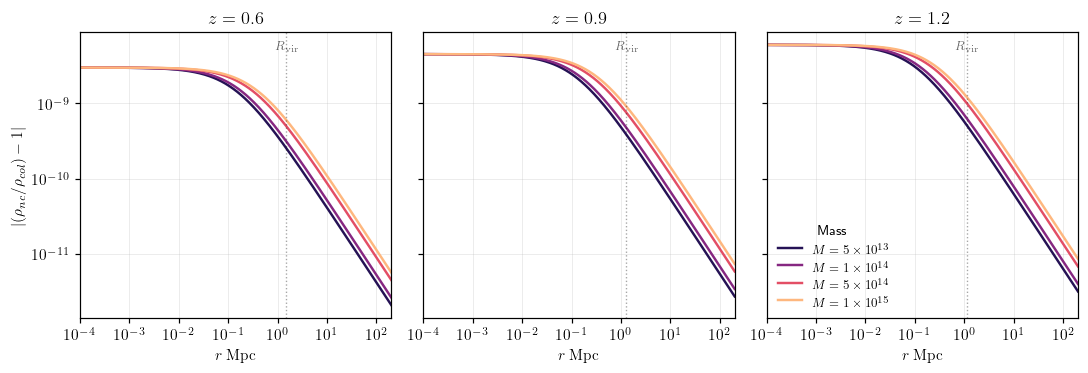

In [9]:
fig, axs = plot_facets_by_z(
    results,
    zs,
    Ms,
    y_getter=lambda o: o["abs_rel_inner"]["nfw"],
    ylabel=r"$|(\rho_{nc}/\rho_{col}) - 1|$",
    mark_radii=["rvir"]
)
#plt.savefig("final_error_nfw.svg", dpi=200)
plt.show()


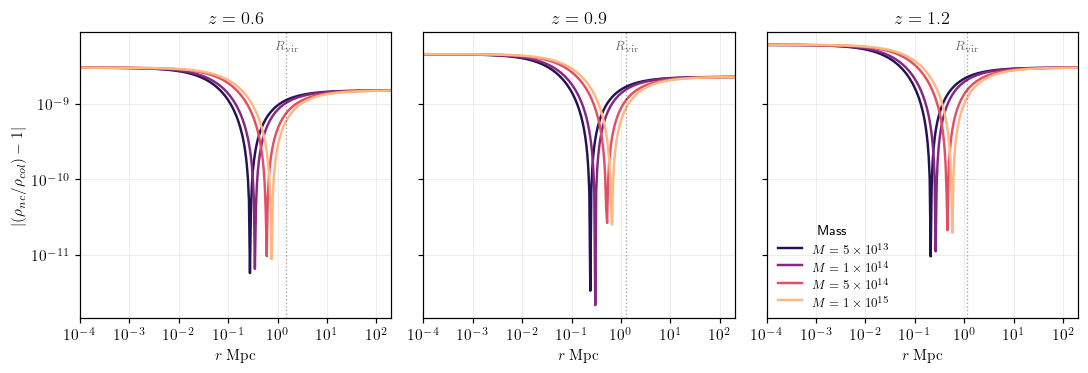

In [10]:
fig, axs = plot_facets_by_z(
    results,
    zs,
    Ms,
    y_getter=lambda o: o["abs_rel_inner"]["hern"],
    ylabel=r"$|(\rho_{nc}/\rho_{col}) - 1|$",
    mark_radii=["rvir"]
)
#plt.savefig("final_error_hern.svg", dpi=200)
plt.show()



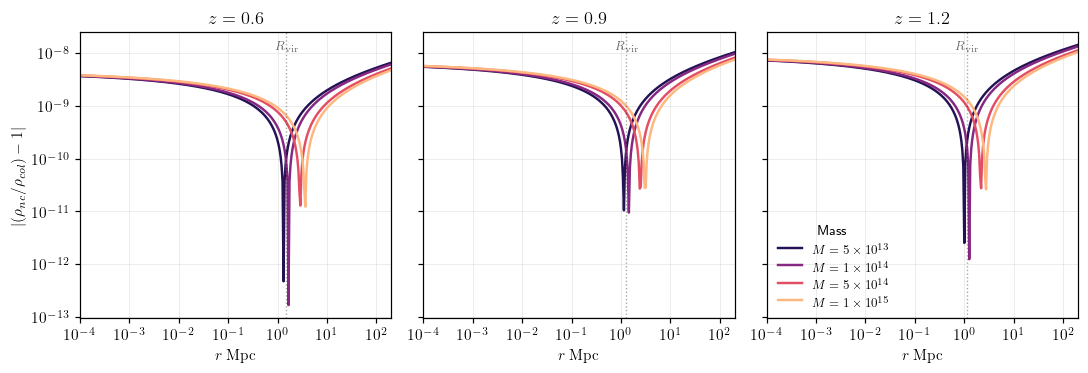

In [11]:
fig, axs = plot_facets_by_z(
    results,
    zs,
    Ms,
    y_getter=lambda o: o["abs_rel_inner"]["ein"],
    ylabel=r"$|(\rho_{nc}/\rho_{col}) - 1|$",
    mark_radii=["rvir"]
)
#plt.savefig("final_error_ein.svg", dpi=200)
plt.show()



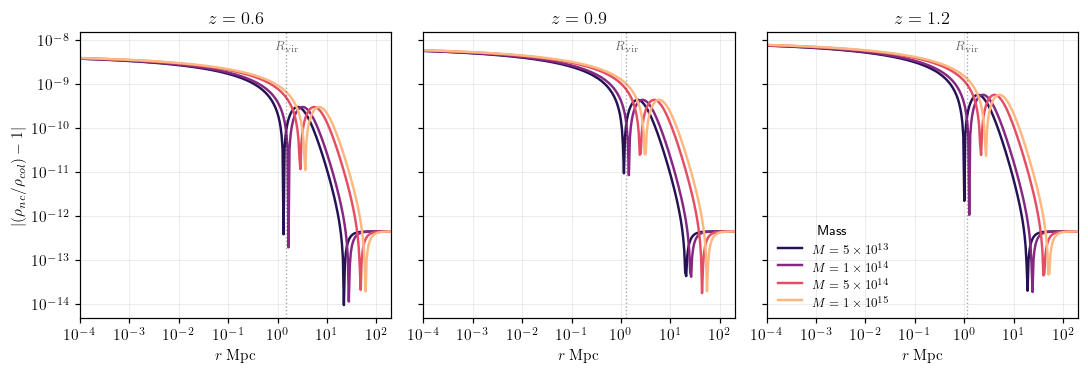

In [12]:
fig, axs = plot_facets_by_z(
    results,
    zs,
    Ms,
    y_getter=lambda o: o["abs_rel_outer"]["mean"],
    ylabel=r"$|(\rho_{nc}/\rho_{col}) - 1|$",
    mark_radii=["rvir"]
)
#plt.savefig("final_error_mean.svg", dpi=200)
plt.show()



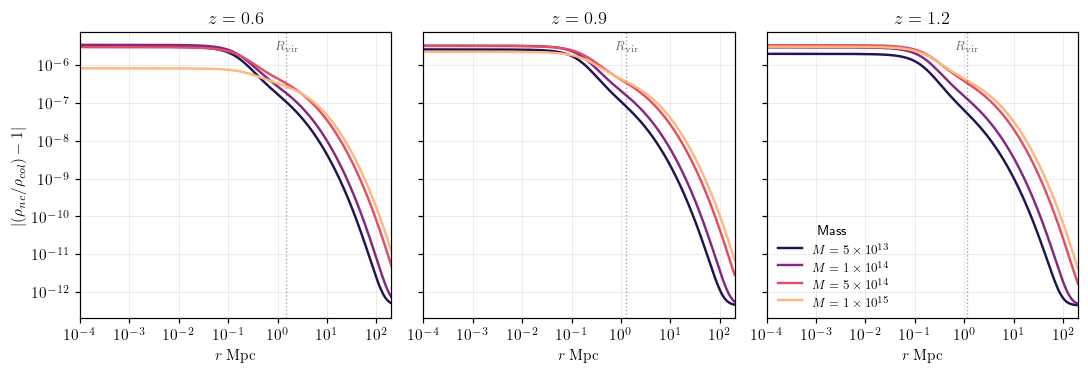

In [13]:
fig, axs = plot_facets_by_z(
    results,
    zs,
    Ms,
    y_getter=lambda o: o["abs_rel_outer"]["pl"],
    ylabel=r"$|(\rho_{nc}/\rho_{col}) - 1|$",
    mark_radii=["rvir"]
)
#plt.savefig("final_error_pl.svg", dpi=200)
plt.show()



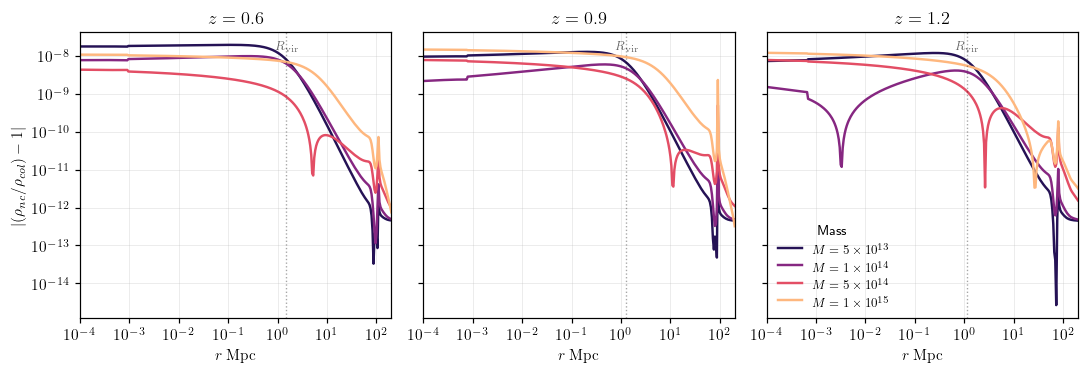

In [14]:
fig, axs = plot_facets_by_z(
    results,
    zs,
    Ms,
    y_getter=lambda o: o["abs_rel_outer"]["cf"],
    ylabel=r"$|(\rho_{nc}/\rho_{col}) - 1|$",
    mark_radii=["rvir"]
)
#plt.savefig("final_error_cf.svg", dpi=200)
plt.show()


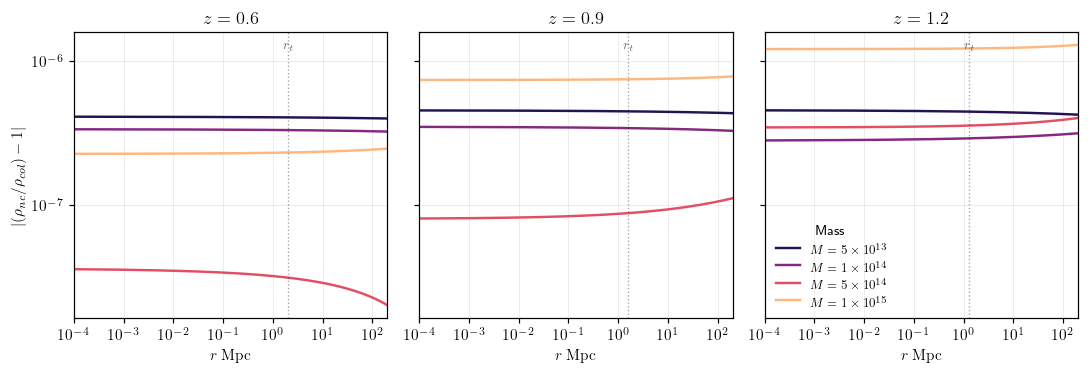

In [15]:
fig, axs = plot_facets_by_z(
    results,
    zs,
    Ms,
    y_getter=lambda o: o["dk14"]["abs_rel"],
    ylabel=r"$|(\rho_{nc}/\rho_{col}) - 1|$",
    mark_radii=["rt"]
)
#plt.savefig("final_error_dk14.svg", dpi=200)
plt.show()


In [16]:
# %%
import numpy as np

def scalar_rms(x):
    """Scalar RMS of an array."""
    x = np.asarray(x)
    return np.sqrt(np.mean(x**2))


# ---- collect residuals from all cases ----
profiles = {
    # inner
    "NFW (inner)":       lambda o: o["abs_rel_inner"]["nfw"],
    "Einasto (inner)":   lambda o: o["abs_rel_inner"]["ein"],
    "Hernquist (inner)": lambda o: o["abs_rel_inner"]["hern"],

    # outer
    "Einasto + mean":    lambda o: o["abs_rel_outer"]["mean"],
    "Einasto + PL":      lambda o: o["abs_rel_outer"]["pl"],
    "Einasto + 2-halo":  lambda o: o["abs_rel_outer"]["cf"],

    # DK14
    "DK14":              lambda o: o["dk14"]["abs_rel"],
}

print("Summary of relative differences (all z, all M, all r)\n")

for name, getter in profiles.items():
    vals = np.concatenate([getter(o) for o in results])

    max_rel = np.max(vals)
    rms_rel = scalar_rms(vals)

    print(f"{name:18s} : "
          f"max = {max_rel:.3e} , "
          f"RMS = {rms_rel:.3e}")


Summary of relative differences (all z, all M, all r)

NFW (inner)        : max = 6.003e-09 , RMS = 3.137e-09
Einasto (inner)    : max = 1.437e-08 , RMS = 4.386e-09
Hernquist (inner)  : max = 6.002e-09 , RMS = 3.254e-09
Einasto + mean     : max = 7.574e-09 , RMS = 3.339e-09
Einasto + PL       : max = 3.430e-06 , RMS = 1.964e-06
Einasto + 2-halo   : max = 1.986e-08 , RMS = 7.893e-09
DK14               : max = 1.286e-06 , RMS = 5.074e-07
